In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [45]:
ppp = pd.read_csv('../data/cleaned_ppp.csv')
ppp.head()

,LoanStatus,Term,SBAGuarantyPercentage,InitialApprovalAmount,CurrentApprovalAmount,JobsReported,UTILITIES_PROCEED,PAYROLL_PROCEED,MORTGAGE_INTEREST_PROCEED,RENT_PROCEED,...,Race,Ethnicity,Gender,Veteran,ProcessingMethod,ServicingLenderLocationID,OriginatingLenderLocationID,NAICSCode,CD,BorrowerZip
0,1,24,100,18457.00,18457.00,3,0.0,18457.00,0.0,0.0,...,Unanswered,Unknown/NotStated,Unanswered,Unanswered,PPP,9551,9551,312111,CT-04,06853-1207
1,1,24,100,18457.00,18457.00,6,0.0,18457.00,0.0,0.0,...,Asian,Unknown/NotStated,Female Owned,Unanswered,PPP,9551,9551,812113,CT-01,06107-2103
2,1,60,100,18456.65,18456.65,2,1.0,18450.65,0.0,0.0,...,White,Not Hispanic or Latino,Female Owned,Non-Veteran,PPS,93682,93682,721191,CT-02,06278-1421
3,1,60,100,18456.00,18456.00,1,1.0,18455.00,0.0,0.0,...,White,Not Hispanic or Latino,Male Owned,Non-Veteran,PPP,93490,93490,561730,CT-02,06357-1742
4,1,60,100,18455.00,18455.00,5,0.0,18455.00,0.0,0.0,...,Unanswered,Unknown/NotStated,Unanswered,Unanswered,PPP,433860,529111,445120,CT-01,06111-2212


Critical: when reading in dataset, numeric code categories will be interpreted as numeric.
We must always identify these and reset the dtype.

In [46]:
num_code_features = ['ServicingLenderLocationID', 'NAICSCode', 'OriginatingLenderLocationID', 'CD', 'BorrowerZip']

for p in num_code_features:
    ppp[p] = ppp[p].astype(str)

In [47]:
ppp.dtypes

LoanStatus                       int64
Term                             int64
SBAGuarantyPercentage            int64
InitialApprovalAmount          float64
CurrentApprovalAmount          float64
JobsReported                     int64
UTILITIES_PROCEED              float64
PAYROLL_PROCEED                float64
MORTGAGE_INTEREST_PROCEED      float64
RENT_PROCEED                   float64
REFINANCE_EIDL_PROCEED         float64
HEALTH_CARE_PROCEED            float64
DEBT_INTEREST_PROCEED          float64
BusinessType                    object
RuralUrbanIndicator             object
LMIIndicator                    object
HubzoneIndicator                object
BusinessAgeDescription          object
Race                            object
Ethnicity                       object
Gender                          object
Veteran                         object
ProcessingMethod                object
ServicingLenderLocationID       object
OriginatingLenderLocationID     object
NAICSCode                

In [66]:
numeric_features = ppp.dtypes[ppp.dtypes != 'object']
subset_cols = numeric_features.index.to_list()

In [67]:
# To speed up computation, reduce the dimensionality
subset_cols = subset_cols + ['BusinessType', 'ProcessingMethod'] #  'OriginatingLenderLocationID', 'BorrowerZip', 'NAICSCode', 'LMIIndicator', 'RuralUrbanIndicator', 
# subset_cols
subset_cols

['LoanStatus',
 'Term',
 'SBAGuarantyPercentage',
 'InitialApprovalAmount',
 'CurrentApprovalAmount',
 'JobsReported',
 'UTILITIES_PROCEED',
 'PAYROLL_PROCEED',
 'MORTGAGE_INTEREST_PROCEED',
 'RENT_PROCEED',
 'REFINANCE_EIDL_PROCEED',
 'HEALTH_CARE_PROCEED',
 'DEBT_INTEREST_PROCEED',
 'BusinessType',
 'ProcessingMethod']

Term	0.364957
20	BusinessType_Sole Proprietorship	0.220616
32	JobsReported	0.109977
31	CurrentApprovalAmount	

In [112]:
subset_cols = ['LoanStatus', 'Term', 'BusinessType'] #'JobsReported', 'CurrentApprovalAmount']

In [113]:
subset_ppp = ppp[subset_cols]
subset_ppp.columns

Index(['LoanStatus', 'Term', 'BusinessType'], dtype='object')

In [114]:
# Define X and y
X = subset_ppp.drop(columns=['LoanStatus'])
y = subset_ppp['LoanStatus']

In [115]:
baseline_accuracy = y.value_counts(normalize=True)[1]
y.value_counts(normalize=True)

LoanStatus
1    0.908
0    0.092
Name: proportion, dtype: float64

### Preprocessing 
#### OneHotEncoder to dummify the categorical features

In [116]:
# Make a list of categorical features
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

In [117]:
# Preprocessing pipeline for categorical features
preprocessor = ColumnTransformer(transformers=[
    ('oh', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)  
])

In [118]:
# Define the Random Forest model with preprocessing and classifier
# Use default tuning parameters
rf = RandomForestClassifier(n_estimators=5, max_depth=3, )

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', rf)
])

In [119]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [120]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('oh',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['BusinessType']),
                                                 ('num', StandardScaler(),
                                                  ['Term'])])),
                ('rf', RandomForestClassifier(max_depth=3, n_estimators=5))])

In [121]:
pipe.score(X_train, y_train)

0.9343268236458399

In [122]:
pipe.score(X_test, y_test)

0.9343260828985146

In [123]:
# Reassemble the feature names so that we can map these correctly to feature importances

transformed_feature_names = pipe.named_steps['preprocessor'] \
                                 .named_transformers_['oh'] \
                                 .get_feature_names_out(categorical_cols).tolist()
all_feature_names = transformed_feature_names + numerical_cols
# all_feature_names

In [124]:
# Get feature importances from the trained model
feature_importances = pipe.named_steps['rf'].feature_importances_

In [125]:
# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})
top_features = importance_df.sort_values(by='Importance', ascending=False)
top_features.head(10)

,Feature,Importance
26,Term,0.794458
5,BusinessType_Corporation,0.111829
10,BusinessType_Limited Liability Company(LLC),0.051019
20,BusinessType_Sole Proprietorship,0.021951
18,BusinessType_Self-Employed Individuals,0.012231
8,BusinessType_Independent Contractors,0.004418
14,BusinessType_Partnership,0.003434
21,BusinessType_Subchapter S Corporation,0.000642
3,BusinessType_501(c)6 – Non Profit Membership,0.000010
12,BusinessType_Non-Profit Childcare Center,0.000008


In [126]:
# Examine y predictions
y_pred = pipe.predict(X_test)
pd.Series(y_pred).value_counts(normalize=True)

1    0.972678
0    0.027322
Name: proportion, dtype: float64

In [127]:
# Examine the confusion matrix
cm = confusion_matrix(y_test, y_pred)

In [128]:
print(cm)

[[ 12130  29388]
 [   165 408313]]


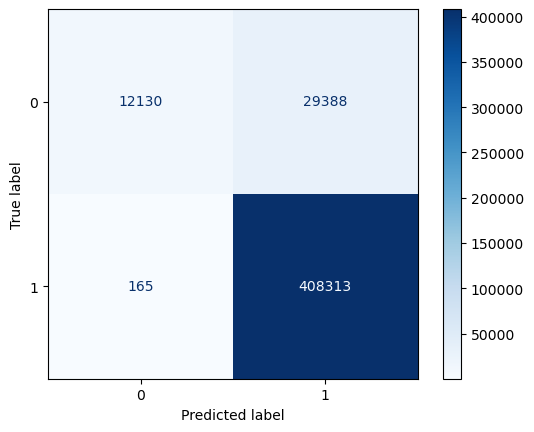

In [129]:
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, cmap='Blues');

In [130]:
# Compute overall accuracy from confusion matrix
overall_accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()

In [131]:
# Calculate precision, recall, and F1-score for each class
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
# recall = cm.diagonal() / (cm.sum(axis=1) + 1)
# f1_score = 2 * (precision * recall) / (precision + recall)

In [132]:
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
# print(f"Recall (Sensitivity): {recall}")
# print(f"F1-Score: {f1_score}")

Overall Accuracy: 0.9343
Baseline Accuracy: 0.9080
Precision: 0.9329


# TO-DO >>>

## Data cleaning
~~collapse target into binary~~

## Holdout - best practices 
split train val test 80 10 10

### Improving performance
## The numerica columns
0) add all numeric features back in
1) feature engineer multicollinear PROCEEDS variables

## Feature engineering to handle categorical features
exclude categorical vals where there are too many unique values

how to narrow down cat cols:
1) engineer feature to reduce number of unique values by doing top 5, and 'other'
2) ordinal labeling
3) examine feature importance and drop least important, then retrain

### Downsample as needed until it finishes within reasonable time

## Scale back up to more data 
Google colab for scale up

# Optional
cross-validation -- why do we do this
~~no need to boostrap resample, sufficient to binarize~~
~~NN keras~~

## Other kinds of models to try
### Ensembling an ensemble could be interesting
0) RandomForest
1) XGBoost
2) knn
3) SVM
4) Multilayer perceptron NN - fewer hyperparameters